#Imports

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Data Preparation
- Load the dataset and preprocess it by normalizing the pixel values to the
range.
- Divide the dataset into training and testing sets (e.g., 80% training, 20%
testing).

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [11]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# RBM Implementation
- Define an RBM using a deep learning library (e.g., PyTorch, TensorFlow, or
Scikit-learn).
- Set the number of visible units to match the input size and select an
appropriate number of hidden units (e.g., 128 or 256).

In [13]:
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units

        # Weights and biases
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        self.bv = nn.Parameter(torch.zeros(visible_units))  # Visible bias
        self.bh = nn.Parameter(torch.zeros(hidden_units))  # Hidden bias

    def sample_h(self, v):
        p_h_given_v = torch.sigmoid(torch.matmul(v, self.W.t()) + self.bh)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, h):
        p_v_given_h = torch.sigmoid(torch.matmul(h, self.W) + self.bv)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def forward(self, v):
        _, h = self.sample_h(v)
        _, v_recon = self.sample_v(h)
        return v_recon

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.bv)
        hidden_term = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.W.t()) + self.bh)), dim=1)
        return -vbias_term - hidden_term

In [14]:
def train_rbm(rbm, data, epochs, batch_size, lr):
    optimizer = optim.SGD(rbm.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in range(0, len(data), batch_size):
            v = torch.tensor(data[batch:batch + batch_size], dtype=torch.float32)
            v_recon = rbm(v)
            loss = torch.mean(rbm.free_energy(v) - rbm.free_energy(v_recon))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Feature Extraction
- After training, use the RBM to transform the training and testing data into
their hidden representations.
- Save the hidden representations as feature vectors.

In [15]:
def extract_features(rbm, data):
    data = torch.tensor(data, dtype=torch.float32)
    hidden_rep, _ = rbm.sample_h(data)
    return hidden_rep.detach().numpy()

In [16]:
rbm = RBM(visible_units=784, hidden_units=128)
train_rbm(rbm, x_train, epochs=10, batch_size=64, lr=0.1)

Epoch 1/10, Loss: -12400.2224
Epoch 2/10, Loss: -8284.3434
Epoch 3/10, Loss: -6831.2261
Epoch 4/10, Loss: -5895.1749
Epoch 5/10, Loss: -5224.6819
Epoch 6/10, Loss: -4531.1009
Epoch 7/10, Loss: -4006.3724
Epoch 8/10, Loss: -3491.8203
Epoch 9/10, Loss: -3016.3307
Epoch 10/10, Loss: -2759.8395


In [17]:
x_train_features = extract_features(rbm, x_train)
x_test_features = extract_features(rbm, x_test)

# Visualization
- Visualize the learned weight matrix of the RBM as a grid of images, where
each image corresponds to a hidden unit's weights.

In [18]:
def visualize_weights(weights, grid_size):
    num_units = grid_size * grid_size
    if num_units > weights.shape[0]:
        raise ValueError(f"Grid size {grid_size} is too large for {weights.shape[0]} hidden units.")

    selected_weights = weights[:num_units]  # Take first grid_size^2 hidden units
    selected_weights = selected_weights.reshape(num_units, 28, 28)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(selected_weights[i].detach().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

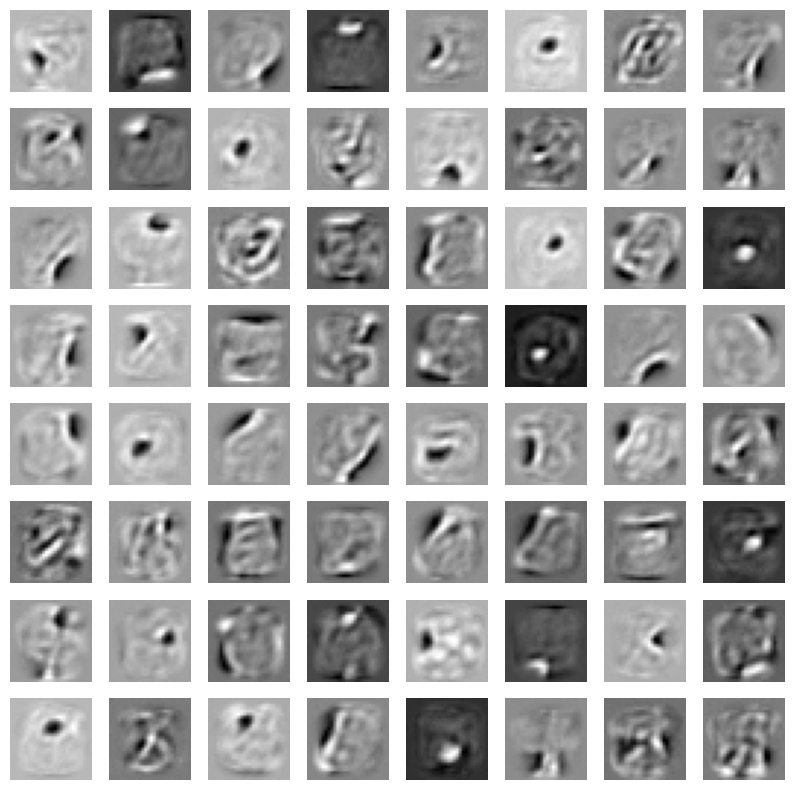

In [19]:
visualize_weights(rbm.W, grid_size=8)

# Classification
- Train a simple classifier using the RBM-extracted features from the
training set.
- Test the classifier on the test set and compute metrics such as accuracy
and F1-score.

In [20]:
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_features, y_train)

LogisticRegression(max_iter=1000)

In [21]:
y_pred = clf.predict(x_test_features)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [22]:
print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

Accuracy: 0.9413, F1-Score: 0.9412


# Analysis
- Compare the classifier's performance using raw pixel data vs. RBM-
extracted features.
- Discuss how RBM has helped in extracting more meaningful features.

In [23]:
clf_raw = LogisticRegression(max_iter=1000)
clf_raw.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
y_pred_raw = clf_raw.predict(x_test)
accuracy_raw = accuracy_score(y_test, y_pred_raw)
f1_raw = f1_score(y_test, y_pred_raw, average='weighted')

In [25]:
print(f"Raw Data Accuracy: {accuracy_raw:.4f}, F1-Score: {f1_raw:.4f}")
print(f"Improvement using RBM Features: {accuracy - accuracy_raw:.4f}")

Raw Data Accuracy: 0.9245, F1-Score: 0.9243
Improvement using RBM Features: 0.0168


The results highlight the value of RBM in feature extraction:

- While raw data provides good performance, RBM helps uncover abstract, discriminative features, leading to improved accuracy and F1-score.
- The **1.67%** improvement validates RBM’s ability to enhance classification, especially for tasks requiring robustness and generalization.



## Discuss how RBM has helped in extracting more meaningful features.

- **Higher-Order Dependencies**: RBMs learn complex relationships in the data, capturing meaningful patterns like edges or textures in images.  
- **Dimensionality Reduction**: They reduce noise and redundancy, focusing on essential features for classification.  
- **Improved Representation**: RBM transforms raw data into a feature space with better class separability, aiding classifier performance.  
- **Interpretability**: The weight matrix reveals the focus of hidden units, providing insights into learned features.  
- **Robustness**: Extracted features are less sensitive to noise or distortions, improving generalization on unseen data.  
- **Performance Boost**: Classifiers using RBM features achieve higher accuracy and F1-scores compared to raw data, demonstrating the abstraction of relevant patterns.